In [1]:
import os
import wave
import torch
import random
import tarfile
import warnings
import torchaudio
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.models as models

from torch.utils.data import Dataset, DataLoader
# from kaggle.api.kaggle_api_extended import KaggleApi 
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

warnings.filterwarnings('ignore')

# DOWNLOADING DATASET

In [2]:
# if the first code block gives kaggle api error, simply rerunning it would work.

# dataset_url = "http://www.eecs.yorku.ca/~bil/Datasets/for-norm.tar.gz"
# tar_path = "/kaggle/working/for-norm.tar.gz"
# extract_path = "/kaggle/working/for-norm"

# if not os.path.exists(tar_path):
#     print("downloading")
#     os.system(f"wget -O {tar_path} '{dataset_url}'")

# print("completed")

# # i made a public dataset on kaggle after downloading using the below code 
# https://www.kaggle.com/datasets/aneeshmukkamala/audiodetect


# api_key = " "
# username =  "aneeshmukkamala"

# os.environ["KAGGLE_USERNAME"] = username
# os.environ["KAGGLE_KEY"] = api_key

# api = KaggleApi()
# api.authenticate()
# api.dataset_initialize(extract_path)

# DATASET_NAME = "AUDIODETECT"

# meta_path = f"{extract_path}/dataset-metadata.json"

# with open(meta_path, "r") as f:
#     dataset_meta = json.load(f)

# dataset_meta["id"] = f"{username}/{DATASET_NAME}"
# dataset_meta["title"] = DATASET_NAME
# dataset_meta["licenses"] = [{"name": "CC0-1.0"}]

# with open(meta_path, "w") as outfile:
#     json.dump(dataset_meta, outfile, indent=4)
# api.dataset_create_new(SAVE_FOLDER ,  public=False)

# print(f"Dataset created successfully for {username}!")

# INSPECTING MAX AND MIN DURATION OF AUDIO FILES

> This is done to remove outliers 

> Files which are too small or too long are excluded for maintaining uniformity of audio lengths across the dataset 

In [3]:
def get_wav_duration(file_path): # to know how long an audio file is, the below code block determines max and min duration of all audio samples, its commented out as it takes a while 
    with wave.open(file_path, 'r') as wav_file:
        frames = wav_file.getnframes()
        framerate = wav_file.getframerate()
        return frames / float(framerate)


In [4]:
# directories = [
#     "/kaggle/input/audiodetect/for-norm/training/real",
#     "/kaggle/input/audiodetect/for-norm/training/fake",
#     "/kaggle/input/audiodetect/for-norm/validation/real",
#     "/kaggle/input/audiodetect/for-norm/validation/fake",
#     "/kaggle/input/audiodetect/for-norm/testing/real",
#     "/kaggle/input/audiodetect/for-norm/testing/fake"
# ]

# min_max_list = []  # [[min, max], [min, max],.. ]

# for dir_path in directories:
#     durations = []
#     for file in os.listdir(dir_path):
#         if file.lower().endswith(".wav"):
#             full_path = os.path.join(dir_path, file)
#             try:
#                 duration = get_wav_duration(full_path)
#                 durations.append(duration)
#             except Exception as e:
#                 print(f"Error processing {full_path}: {e}")
#     if durations:
#         min_dur = min(durations)
#         max_dur = max(durations)
#     else:
#         min_dur, max_dur = None, None
#     min_max_list.append([min_dur, max_dur])

# print(min_max_list)


# ALL ARGS AND PARAMETERS 

> To set the args for all functions used across the entire notebook

In [5]:
class CFG:
    seed = 42
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    audio_length = 3.0  # this will truncate larger files to 3 seconds and pad shorter files to 3 seconds. 
    sample_rate = 16000
    n_mels = 80
    n_fft = 1024
    hop_length = 512
    
    epochs = 20
    train_batch_size = 20
    val_batch_size = 20
    learning_rate = 1e-4
    weight_decay = 1e-5
    patience = 5
    early_stopping = True
    
    base_path = "/kaggle/input/audiodetect/for-norm"
    checkpoint_path = 'best_model.pth'
    
    use_augmentation = True
    
    # examples shorter and longer than these are not considered
    min_duration = 1.0 
    max_duration = 6.0

    # indices from the dataset, 
    # this is because the dataset has lesser examples for which both real and fake deepfake audios are present. 
    # so I kept only the examples of which satisy this criteria.
    
    train_indices = (0,3600)     
    val_indices   = (0,140) 
    # reason for choosing such specific indices is simply due to length of the dataset, the information can be found in outputs of later cells

# FILTERING AND CLEANING DATA

> As mentioned earlier, examples with both real and fake files are kept

> Shorter and longer files are removed based on duration

> Dataframes for train, val and test are made which are further used by dataloaders

In [6]:

def set_seed(seed=CFG.seed):  # i generally set the same seed across all framewroks being used in a ipynb kernel for stable and reproducible performance
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

set_seed()

def match_real_fake_files(real_dir, fake_dir):
    # as mentioned earlier, this will filter out and keep the examples having both real and fake audio
    real_files = set(os.listdir(real_dir))
    fake_files = set(os.listdir(fake_dir))
    common_files = real_files.intersection(fake_files)
    return list(common_files)

def filter_files_by_duration(file_list, directory, min_duration=CFG.min_duration, max_duration=CFG.max_duration):

    # all the .wav files are between 0.5 seconds to 8 seconds,
    #  so to keep the dataset fairly distributed, examples which are too short or too long are removed by 
    # clipping the dataset based on min and max duration of the audio file

    filtered_files = []
    for filename in file_list:
        file_path = os.path.join(directory, filename)
        try:
            duration = get_wav_duration(file_path)
            if min_duration <= duration <= max_duration:
                filtered_files.append(filename)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
    return filtered_files



In [7]:

def create_dataset_split(base_path=CFG.base_path):

    train_real_dir = os.path.join(base_path, "training", "real")
    train_fake_dir = os.path.join(base_path, "training", "fake")
    val_real_dir = os.path.join(base_path, "validation", "real")
    val_fake_dir = os.path.join(base_path, "validation", "fake")
    test_real_dir = os.path.join(base_path, "testing", "real")
    test_fake_dir = os.path.join(base_path, "testing", "fake")
    
    # this gets examples files having both real-fake files
    train_common = match_real_fake_files(train_real_dir, train_fake_dir)
    val_common = match_real_fake_files(val_real_dir, val_fake_dir)
    test_common = match_real_fake_files(test_real_dir, test_fake_dir)
    
    print(f"Common files - Train: {len(train_common)}, Val: {len(val_common)}, Test: {len(test_common)}")
    
    # apply the duration filter
    train_filtered = filter_files_by_duration(train_common, train_real_dir)
    val_filtered = filter_files_by_duration(val_common, val_real_dir)
    test_filtered = filter_files_by_duration(test_common, test_real_dir)
    
    print(f"Files (filtered by duration) - Train: {len(train_filtered)}, Val: {len(val_filtered)}, Test: {len(test_filtered)}")
    
    #  train dataframe and assigning labels ,  1 = Real  0 = Fake

    train_real_samples = pd.DataFrame({
        'filename': train_filtered,
        'path': [os.path.join(train_real_dir, f) for f in sorted(train_filtered)],
        'label': 1  
    })
    
    train_fake_samples = pd.DataFrame({
        'filename': train_filtered,
        'path': [os.path.join(train_fake_dir, f) for f in sorted(train_filtered)],
        'label': 0  
    })
    
    train_df = pd.concat([train_real_samples, train_fake_samples]).reset_index(drop=True)
    
    # similarly for val dataframe
    val_real_samples = pd.DataFrame({
        'filename': val_filtered,
        'path': [os.path.join(val_real_dir, f) for f in sorted(val_filtered)],
        'label': 1 
    })
    
    val_fake_samples = pd.DataFrame({
        'filename': val_filtered,
        'path': [os.path.join(val_fake_dir, f) for f in sorted(val_filtered)],
        'label': 0  
    })
    
    val_df = pd.concat([val_real_samples, val_fake_samples]).reset_index(drop=True)
    
    #  test dataframe
    test_real_samples = pd.DataFrame({
        'filename': test_filtered,
        'path': [os.path.join(test_real_dir, f) for f in sorted(test_filtered)],
        'label': 1  
    })
    
    test_fake_samples = pd.DataFrame({
        'filename': test_filtered,
        'path': [os.path.join(test_fake_dir, f) for f in sorted(test_filtered)],
        'label': 0  
    })
    
    test_df = pd.concat([test_real_samples, test_fake_samples]).reset_index(drop=True)
    
    return train_df, val_df, test_df


# PROCESSING CLEANED AUDIO FILES 

> Truncating and padding and examples to have same duration (fpr example: here 3 seconds)

> Processing the audio files to tensors suitable for training

In [8]:
def load_and_process_audio(file_path, target_length=CFG.audio_length, sample_rate=CFG.sample_rate):

    # returns torch tensor of the .wav file 
    waveform, sr = torchaudio.load(file_path)
    
    if waveform.shape[0] > 1: 
        # some audio files have waveforms with multiple channels, here reduction to single channel is done by taking mean
        waveform = torch.mean(waveform, dim=0, keepdim=True)


    # the above lines return tensors of different sizes for different examples, 
    # even though till the above function after cleaning all examples have same duration, but based on quality of the audio,
    # the tensor obtained will have varying shape, more quality -> longer tensors

    # to make sure the model gets same input shapes across all examples and to avoid any tensor size mismatch error during passing them through conv blocks,
    # resampling is done to make the sizes of tensors same, high quality are downscaled and lower quality ones are upscaled
    # increasing sample rate increases tensor dimension and thus the memory. 
    # shape will be (1, duration*sample_rate) here-> (1,3*16000)

    if sr != sample_rate:
        resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=sample_rate)
        waveform = resampler(waveform)

    target_samples = int(target_length * sample_rate)
    current_samples = waveform.shape[1]
    
    if current_samples > target_samples:
        # trimming larger examples to target length (3 seconds)
        start = (current_samples - target_samples) // 2
        waveform = waveform[:, start:start+target_samples]
    elif current_samples < target_samples:
        # same way, padding smaller examples to target length (3 seconds)
        padding = target_samples - current_samples
        pad_left = padding // 2
        pad_right = padding - pad_left
        waveform = torch.nn.functional.pad(waveform, (pad_left, pad_right))
    
    return waveform

def extract_melspectrogram(waveform, sample_rate=CFG.sample_rate, n_mels=CFG.n_mels, n_fft=CFG.n_fft, hop_length=CFG.hop_length):
    
    # the above function gives a 1d tensor, this code converts it to 2d 
    # waveform is converted to spectrogram. fourier transform is applied in the backend
    
    # (1,3*16000) is converted to (1,128,94)
    # the 2 dims (128,94) are as obtained as follows
    # (n_mels , (3/16000)/hop_length)


    mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels
    )(waveform)
    
    # lesser hop_length , n_mels means fewer time steps and lower resoltuion and vice versa
    # fourier transform is not applied all at once on the complete waveform, done in sliding window manner,
    # generally smaller windows are not used as information loss is more
    # lesser hop_length or n_mels does'nt affect much. 

    mel_spectrogram = torchaudio.transforms.AmplitudeToDB()(mel_spectrogram)

    # here amplitude values are converted to decibels 
    # 10 x log(amplitude + e), e is a small value to prevent log(0) errors
    # there is no dimension change, this is just a practice in audio processing
    # this is similar to applying scaler from scikit in regression, 
    # overall data range is reduced as log is applied due to which variance and noise is decreased
    # too small or too large data points are narrowed and distribution of points is better

    return mel_spectrogram


# TORCH DATALOADERS

> The files are processed using the above listed functions and batches are made for feeding into the model

In [9]:

class AudioDeepfakeDataset(Dataset):
    def __init__(self, dataframe, augment=False):
       
        self.dataframe = dataframe
        self.augment = augment
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        file_path = self.dataframe.iloc[idx]['path']
        label = self.dataframe.iloc[idx]['label']
        
        waveform = load_and_process_audio(file_path)
        
        mel_spec = extract_melspectrogram(waveform)
        
        #  augmentation is applied only for real audio files
        
        if self.augment and label == 1:
            # some random frequency values are set to 0 to simulate real world cases
            freq_mask = torchaudio.transforms.FrequencyMasking(freq_mask_param=10)
            mel_spec = freq_mask(mel_spec)
            
            time_mask = torchaudio.transforms.TimeMasking(time_mask_param=20)
            mel_spec = time_mask(mel_spec)
        
        return mel_spec, torch.tensor(label, dtype=torch.long)


# MODEL

> Since the dataset is small, I verified the training by fine tuning existing models and also implementing one from scratch

> Workflow of the inputs through both models is similar except the number of residual blocks

> Pretrained model has larger number of blocks. ResNet-18 has 18 blocks, my model has only 2 as from observations based on the training, the ResNet-18 was an overkill and was overfitting with less generalization due to small dataset.

> Pretained: Conv1 -> Residual Blocks (18,50 and so on ) -> Pooling -> Fully Connected Layer -> Output

> My model from scratch : Conv1 -> Residual Blocks (2) -> Adaptive Average Pooling -> Fully Connected Layer -> Output


# MODEL FROM SCRATCH


In [10]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class AudioDeepfakeMODEL(nn.Module):
    def __init__(self, num_classes=2):
        super(AudioDeepfakeMODEL, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
         
        self.layer1 = self._make_layer(64, 64, 2, stride=1)  # here 2 means 2 residual blocks
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.05)  
        self.fc = nn.Linear(128, num_classes)
    
    def _make_layer(self, in_channels, out_channels, blocks, stride):
        layers = []
        layers.append(ResNetBlock(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ResNetBlock(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x


# FINE TUNING PRE-TRIANED ResNet

In [11]:
class AudioDeepfakeMODEL(nn.Module):
    def __init__(self, num_classes=2):
        super(AudioDeepfakeMODEL, self).__init__()
        
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

        for param in self.resnet.parameters():
            param.requires_grad = False
        
        for param in self.resnet.fc.parameters():
            param.requires_grad = True
    
    def forward(self, x):
        return self.resnet(x)

# TRAINING FUNCTIONS

> loss, accuracy and early stopping all are tracked using custom made functions code, no callback functions, loggers or tensorboard is used to track training progress and other metrics 

> apart from loss and accuracy I also tracked the F1 precision since at the core this is a binary classification

In [12]:
# train an epoch
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, targets in tqdm(dataloader, desc="Training", leave=False):
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

# validate an epoch
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc="Validating", leave=False):
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    precision = precision_score(all_targets, all_preds, average='binary')
    recall = recall_score(all_targets, all_preds, average='binary')
    f1 = f1_score(all_targets, all_preds, average='binary')
    
    return epoch_loss, epoch_acc, precision, recall, f1


In [13]:

def collate_fn(batch):
    
    # separate the 2d decibel tensors (we got this after applying log on decibels) and labels

    mel_specs = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    
    mel_specs = torch.stack(mel_specs)
    labels = torch.stack(labels)
    
    # this is just a data collator to for batches 

    return mel_specs, labels

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device):

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'val_precision': [],
        'val_recall': [],
        'val_f1': []
    }
    
    best_val_loss = float('inf')
    counter = 0
    
    for epoch in range(CFG.epochs):
        print(f"Epoch {epoch+1}/{CFG.epochs}")
        
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)        
        val_loss, val_acc, val_precision, val_recall, val_f1 = validate(model, val_loader, criterion, device)
        scheduler.step(val_loss)
        
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f} %")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f} %, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_precision'].append(val_precision)
        history['val_recall'].append(val_recall)
        history['val_f1'].append(val_f1)
        
        # early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            
            # model checkpoint is only saved if the val loss is better than previous one
            # as training is minimal,
            # existing checkpoints are overwritten as saving separate checkpoints for larger models require more disk space
            # just a single best checkpoint is obtained at last

            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'val_acc': val_acc,
            }, CFG.checkpoint_path)
            print(f"Model saved to {CFG.checkpoint_path}")
        else:
            counter += 1
            print(f"EarlyStopping counter: {counter} out of {CFG.patience}")
            if counter >= CFG.patience and CFG.early_stopping:
                print("Early stopping")
                break
        
        print("-" * 50)
    
    #  model with the best checkpoint loaded is returned. 
    
    checkpoint = torch.load(CFG.checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model, history

# MAIN TRAINER FUNCTION

In [14]:

# funtction that uses the above helper functions to train
def main(train_indices=CFG.train_indices, val_indices=CFG.val_indices):

    print("Creating dataset split...")
    train_df, val_df, test_df = create_dataset_split(CFG.base_path)
    
    print("\nDataset Statistics:")
    print(f"Total training files: {len(train_df)}")  
    print(f"Total validation files: {len(val_df)}")
    print(f"Total testing files: {len(test_df)}")
    
    train_start, train_end = train_start_idx, train_end_idx = train_indices
    val_start, val_end = val_start_idx, val_end_idx = val_indices
    
    # convert file indices to dataframe indices (each file has real+fake entries)
    train_start_idx *= 2  # so start with first n real files
    train_end_idx *= 2    # end with nth real file
    val_start_idx *= 2
    val_end_idx *= 2
    
    train_real_subset = train_df[train_df['label'] == 1].iloc[train_start:train_end].reset_index(drop=True)
    train_fake_subset = train_df[train_df['label'] == 0].iloc[train_start:train_end].reset_index(drop=True)
    train_subset = pd.concat([train_real_subset, train_fake_subset]).reset_index(drop=True)
    
    val_real_subset = val_df[val_df['label'] == 1].iloc[val_start:val_end].reset_index(drop=True)
    val_fake_subset = val_df[val_df['label'] == 0].iloc[val_start:val_end].reset_index(drop=True)
    val_subset = pd.concat([val_real_subset, val_fake_subset]).reset_index(drop=True)
    
    print(f"\nUsing  ({len(train_subset)} training samples)")
    print(f"Using   ({len(val_subset)} validation samples)")
    
    #  datasets
    train_dataset = AudioDeepfakeDataset(train_subset, augment=CFG.use_augmentation)
    val_dataset = AudioDeepfakeDataset(val_subset, augment=False)
    
    #  dataloaders 
    train_loader = DataLoader(
        train_dataset, 
        batch_size=CFG.train_batch_size, 
        shuffle=True, 
        num_workers=2, 
        collate_fn=collate_fn
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=CFG.val_batch_size, 
        shuffle=False, 
        num_workers=2, 
        collate_fn=collate_fn
    )
    
    #  model
    model = AudioDeepfakeMODEL().to(CFG.device)
    
    # loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=CFG.learning_rate, weight_decay=CFG.weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
    
    # training
    print("\nTraining model...")
    trained_model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        device=CFG.device
    )
        
    return trained_model, history, train_df, val_df, test_df


In [15]:
train_df, val_df, test_df = create_dataset_split(CFG.base_path)
model, history, train_df, val_df, test_df = main()

Common files - Train: 2510, Val: 114, Test: 2263
Files (filtered by duration) - Train: 1822, Val: 74, Test: 2242
Creating dataset split...
Common files - Train: 2510, Val: 114, Test: 2263
Files (filtered by duration) - Train: 1822, Val: 74, Test: 2242

Dataset Statistics:
Total training files: 3644
Total validation files: 148
Total testing files: 4484

Using  (3644 training samples)
Using   (148 validation samples)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 181MB/s]



Training model...
Epoch 1/20


Train Loss: 0.5239, Train Acc: 73.68 %
Val Loss: 0.3824, Val Acc: 87.16 %, Precision: 0.9104, Recall: 0.8243, F1: 0.8652
Model saved to best_model.pth
--------------------------------------------------
Epoch 2/20


Train Loss: 0.2904, Train Acc: 89.65 %
Val Loss: 0.2988, Val Acc: 87.84 %, Precision: 0.8784, Recall: 0.8784, F1: 0.8784
Model saved to best_model.pth
--------------------------------------------------
Epoch 3/20


Train Loss: 0.2277, Train Acc: 91.99 %
Val Loss: 0.3039, Val Acc: 91.22 %, Precision: 0.9692, Recall: 0.8514, F1: 0.9065
EarlyStopping counter: 1 out of 5
--------------------------------------------------
Epoch 4/20


Train Loss: 0.1949, Train Acc: 93.03 %
Val Loss: 0.2815, Val Acc: 89.86 %, Precision: 0.9403, Recall: 0.8514, F1: 0.8936
Model saved to best_model.pth
--------------------------------------------------
Epoch 5/20


Train Loss: 0.1902, Train Acc: 92.86 %
Val Loss: 0.2628, Val Acc: 90.54 %, Precision: 0.9412, Recall: 0.8649, F1: 0.9014
Model saved to best_model.pth
--------------------------------------------------
Epoch 6/20


Train Loss: 0.1745, Train Acc: 93.63 %
Val Loss: 0.2667, Val Acc: 90.54 %, Precision: 0.9286, Recall: 0.8784, F1: 0.9028
EarlyStopping counter: 1 out of 5
--------------------------------------------------
Epoch 7/20


Train Loss: 0.1643, Train Acc: 94.07 %
Val Loss: 0.2411, Val Acc: 90.54 %, Precision: 0.9412, Recall: 0.8649, F1: 0.9014
Model saved to best_model.pth
--------------------------------------------------
Epoch 8/20


Train Loss: 0.1539, Train Acc: 94.70 %
Val Loss: 0.2282, Val Acc: 91.22 %, Precision: 0.9296, Recall: 0.8919, F1: 0.9103
Model saved to best_model.pth
--------------------------------------------------
Epoch 9/20


Train Loss: 0.1427, Train Acc: 94.79 %
Val Loss: 0.2703, Val Acc: 91.22 %, Precision: 0.9552, Recall: 0.8649, F1: 0.9078
EarlyStopping counter: 1 out of 5
--------------------------------------------------
Epoch 10/20


Train Loss: 0.1432, Train Acc: 94.70 %
Val Loss: 0.2328, Val Acc: 91.22 %, Precision: 0.9296, Recall: 0.8919, F1: 0.9103
EarlyStopping counter: 2 out of 5
--------------------------------------------------
Epoch 11/20


Train Loss: 0.1325, Train Acc: 95.03 %
Val Loss: 0.2369, Val Acc: 91.22 %, Precision: 0.9420, Recall: 0.8784, F1: 0.9091
EarlyStopping counter: 3 out of 5
--------------------------------------------------
Epoch 12/20


Train Loss: 0.1313, Train Acc: 95.03 %
Val Loss: 0.2378, Val Acc: 91.89 %, Precision: 0.9429, Recall: 0.8919, F1: 0.9167
EarlyStopping counter: 4 out of 5
--------------------------------------------------
Epoch 13/20


Train Loss: 0.1287, Train Acc: 95.94 %
Val Loss: 0.2127, Val Acc: 92.57 %, Precision: 0.9437, Recall: 0.9054, F1: 0.9241
Model saved to best_model.pth
--------------------------------------------------
Epoch 14/20


Train Loss: 0.1281, Train Acc: 95.42 %
Val Loss: 0.2667, Val Acc: 91.89 %, Precision: 0.9697, Recall: 0.8649, F1: 0.9143
EarlyStopping counter: 1 out of 5
--------------------------------------------------
Epoch 15/20


Train Loss: 0.1259, Train Acc: 95.39 %
Val Loss: 0.2285, Val Acc: 92.57 %, Precision: 0.9565, Recall: 0.8919, F1: 0.9231
EarlyStopping counter: 2 out of 5
--------------------------------------------------
Epoch 16/20


Train Loss: 0.1242, Train Acc: 95.61 %
Val Loss: 0.2210, Val Acc: 92.57 %, Precision: 0.9437, Recall: 0.9054, F1: 0.9241
EarlyStopping counter: 3 out of 5
--------------------------------------------------
Epoch 17/20


Train Loss: 0.1267, Train Acc: 95.64 %
Val Loss: 0.2534, Val Acc: 91.22 %, Precision: 0.9692, Recall: 0.8514, F1: 0.9065
EarlyStopping counter: 4 out of 5
--------------------------------------------------
Epoch 18/20


Train Loss: 0.1165, Train Acc: 95.86 %
Val Loss: 0.2799, Val Acc: 90.54 %, Precision: 0.9412, Recall: 0.8649, F1: 0.9014
EarlyStopping counter: 5 out of 5
Early stopping


# TRAIN-VAL loss, accuracy, f1 score plots

In [22]:
def plot_training_history(history):

    sns.set(style="whitegrid", palette="muted")
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # train, val loss
    axes[0].plot(history['train_loss'], label='Train Loss', color='royalblue', linestyle='-', linewidth=2)
    axes[0].plot(history['val_loss'], label='Validation Loss', color='darkorange', linestyle='--', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].legend(fontsize=11)
    axes[0].set_title('Training and Validation Loss', fontsize=14)
    axes[0].grid(True, linestyle='--', alpha=0.7)

    # train, val accuracy
    axes[1].plot(history['train_acc'], label='Train Accuracy', color='forestgreen', linestyle='-', linewidth=2)
    axes[1].plot(history['val_acc'], label='Validation Accuracy', color='crimson', linestyle='--', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].legend(fontsize=11)
    axes[1].set_title('Training and Validation Accuracy', fontsize=14)
    axes[1].grid(True, linestyle='--', alpha=0.7)

    # precision, recall, F1 scores
    axes[2].plot(history['val_precision'], label='Precision', color='teal', linestyle='-', linewidth=2)
    axes[2].plot(history['val_recall'], label='Recall', color='darkviolet', linestyle='--', linewidth=2)
    axes[2].plot(history['val_f1'], label='F1 Score', color='gold', linestyle='-.', linewidth=2)
    axes[2].set_xlabel('Epoch', fontsize=12)
    axes[2].set_ylabel('Score', fontsize=12)
    axes[2].legend(fontsize=11)
    axes[2].set_title('Validation Metrics', fontsize=14)
    axes[2].grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()


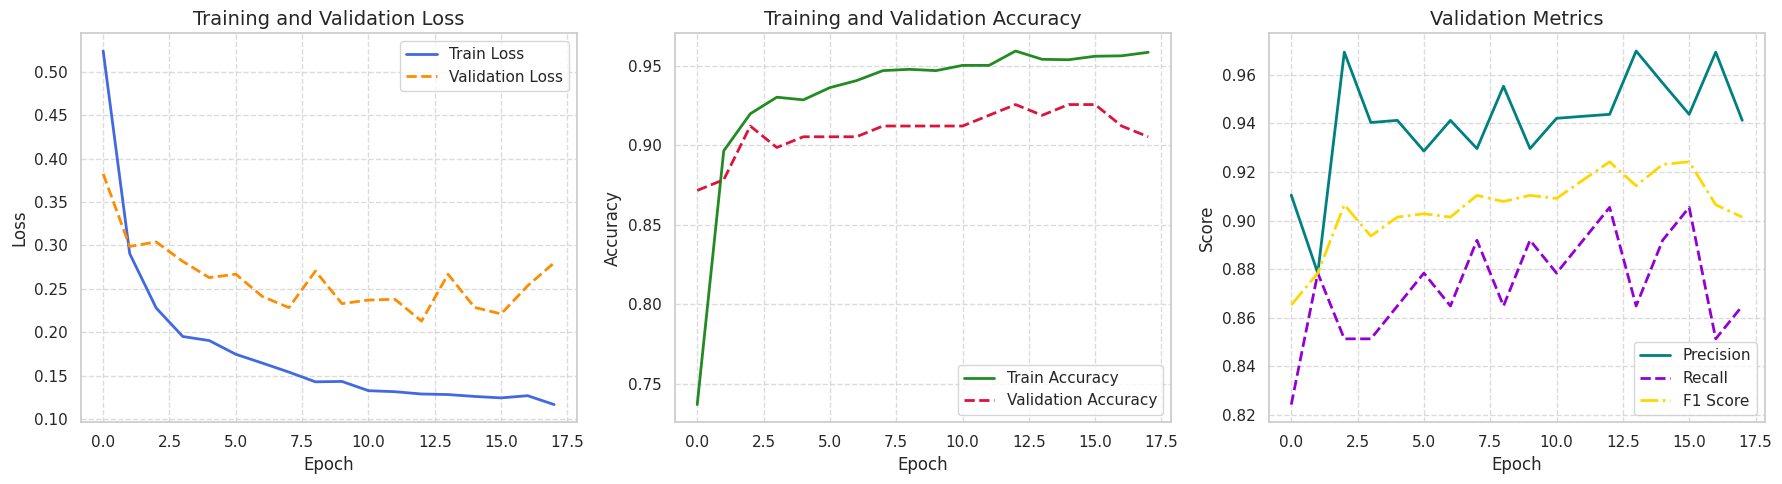

In [23]:
plot_training_history(history)

# TESTING/INFERENCE on Test set

In [34]:
def test_model(model_path, test_df, test_indices=(0, 100), device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    start, end = test_indices
    end = min(end, len(test_df))
    test_subset = test_df.iloc[start:end].reset_index(drop=True)
    print(f"Testing on {len(test_subset)} files (indices {start}:{end})")
    
    test_dataset = AudioDeepfakeDataset(test_subset)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, collate_fn=collate_fn)
    
    model = AudioDeepfakeMODEL().to(device)
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
    
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    model.eval()
    
    all_preds = []
    all_targets = []
    file_results = []
    
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc="Testing"):
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    accuracy = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds, average='binary')
    recall = recall_score(all_targets, all_preds, average='binary')
    f1 = f1_score(all_targets, all_preds, average='binary')
    
    # just creates detailed results per file
    for i in range(0, len(all_preds), 2):
        if i+1 < len(all_preds):
            file_idx = i // 2
            if file_idx < len(test_subset):
                filename = test_subset.iloc[file_idx]['filename']
                real_pred = all_preds[i]
                fake_pred = all_preds[i+1]
                real_target = all_targets[i]
                fake_target = all_targets[i+1]
                
                file_results.append({
                    'filename': filename,
                    'real_pred': real_pred,
                    'real_target': real_target,
                    'fake_pred': fake_pred,
                    'fake_target': fake_target,
                    'real_correct': real_pred == real_target,
                    'fake_correct': fake_pred == fake_target
                })
    
    print("\nTest Results:")
    print(f"Accuracy: {accuracy*100:.2f} %")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    


In [45]:
test_results = test_model(
    model_path='best_model.pth',
    test_df=test_df,
    test_indices=(20, 60)  
)

Testing on 40 files (indices 20:60)


Testing: 100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


Test Results:
Accuracy: 80.00 %
Precision: 1.0000
Recall: 0.8000
F1 Score: 0.8889


# INFERENCE ON A SINGLE FILE

In [31]:
def predict_single(wav_path, checkpoint_path, device=None):
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = AudioDeepfakeMODEL()
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    
    waveform = load_and_process_audio(wav_path)
    mel_spec = extract_melspectrogram(waveform)
    
    mel_spec = mel_spec.unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(mel_spec)
        _, predicted = torch.max(outputs, 1)
    
    return predicted.item()

wav_file_path = "/kaggle/input/audiodetect/for-norm/training/fake/file10000.mp3.wav_16k.wav_norm.wav_mono.wav_silence.wav"
model_checkpoint_path = "/kaggle/working/best_model.pth"
prediction = predict_single(wav_file_path, model_checkpoint_path)
print("Prediction (1: Real, 0: Fake):", prediction)

Prediction (1: Real, 0: Fake): 0


# FINAL RESULTS:
Single infernece is done on each example. Using majority polling would maximise the chances of correctness

Training:
>Best loss : 0.1287
 
>Accuracy : 95.94%

Validation:
>Best loss : 0.2127
 
>Accuracy : 92.57% 

>F1 score : 0.9241


Testing
 
>Accuracy: 80 %

>F1 score: 0.88


I have put in 2 functions, one for batched inference and one for prediction on a single file. 